In [1]:
# download spacy language model
#!python -m spacy download en_core_web_lg

### Acknowledgement: 
scripts to extract food name entity are partly from Isaac Aderogba at https://deepnote.com/@isaac-aderogba/Spacy-Food-Entities-LMLRnMOsQyGIUwvPLvVlsw

In [81]:
# import libraries
import en_core_web_lg
import pandas as pd
import re
import random
import spacy
from spacy.util import minibatch, compounding
import warnings
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [3]:
##from google.colab import files
##uploaded = files.upload()

In [4]:
food_df = pd.read_csv("./data/food.csv")

In [5]:
food_df

,fdc_id,data_type,description,food_category_id,publication_date
0,344604,branded_food,Tutturosso Green 14.5oz. NSA Italian Diced Tom...,NaN,2019-04-01
1,344605,branded_food,Tutturosso Green 14.5oz. Italian Diced Tomatoes,NaN,2019-04-01
2,344606,branded_food,Honeysuckle White Fresh 97% Ground White Turkey,NaN,2019-04-01
3,344607,branded_food,Honeysuckle White 97% Ground White Turkey,NaN,2019-04-01
4,344608,branded_food,Honeysuckle Whtie 85% Ground Turkey,NaN,2019-04-01
...,...,...,...,...,...
498177,1097501,branded_food,"NEW ZEALAND NATIVE, SPARKLING GREEN TEA WITH M...",NaN,2020-09-29
498178,1097503,branded_food,"OSCAR MAYER, THICK CUT BACON, HARDWOOD SMOKED,...",NaN,2020-09-29
498179,1097505,branded_food,"HARGIS HOUSE, BARBECUE VIENNA SAUSAGES",NaN,2020-09-29
498180,1097507,branded_food,"IRISH POTATO CRISPS, ATLANTIC SEA SALT & IRISH...",NaN,2020-09-29


In [6]:
# diaqualify foods with special characters, lowercase and extract results from "description" column
foods = food_df[food_df["description"].str.contains("[^a-zA-Z ]") == False]["description"].apply(lambda food: food.lower())

In [7]:
foods

749                   honeysuckle white turkey breast roast
750                 honeysuckle white turkey breast cutlets
751       honeysuckle white boneless turkey roast with g...
956        honeysuckle white fresh breakfast turkey sausage
957       honeysuckle white fresh breakfast turkey sausa...
                                ...                        
498123                                 american deli cheese
498131                                   quince fruit paste
498138                          dill cucumbers with paprika
498161                                 mini pink french pie
498181                               extra fine green beans
Name: description, Length: 215938, dtype: object

In [8]:
foods = foods[foods.str.split().apply(len) <= 3]

In [9]:
foods.value_counts()[:25]

ice cream                   1293
potato chips                 643
soda                         637
premium ice cream            517
cut green beans              394
milk chocolate               392
pinto beans                  351
coffee creamer               348
cereal                       345
sparkling water              313
pasta sauce                  296
cookies                      296
protein bar                  286
candy                        286
black beans                  284
tomato ketchup               283
diced tomatoes               281
salsa                        263
tomato sauce                 255
cola                         255
popcorn                      244
sparkling water beverage     235
chocolate candies            235
beef jerky                   227
sour cream                   225
Name: description, dtype: int64

In [10]:
# diaqualify foods with special characters, lowercase and extract results from "description" column
foods = food_df[food_df["description"].str.contains("[^a-zA-Z ]") == False]["description"].apply(lambda food: food.lower())

# filter out foods with more than 3 words, drop any duplicates
foods = foods[foods.str.split().apply(len) <= 3].drop_duplicates()

# print the remaining size
foods.size

39378

In [11]:
foods

1447       david sunflower kernels
1460           david seeds pumpkin
1846        dennisons turkey chili
2017      banquet original patties
2397             texas style beans
                    ...           
497576        summer breeze cakies
497585           garden side salad
497669             smashed avocado
497806            cut candied yams
497807              raw cacao nibs
Name: description, Length: 39378, dtype: object

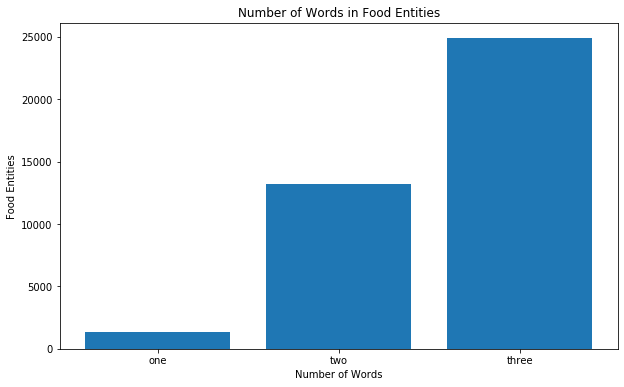

In [12]:
# find one-worded, two-worded and three-worded foods
one_worded_foods = foods[foods.str.split().apply(len) == 1]
two_worded_foods = foods[foods.str.split().apply(len) == 2]
three_worded_foods = foods[foods.str.split().apply(len) == 3]

# create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([1, 2, 3], [one_worded_foods.size, two_worded_foods.size, three_worded_foods.size])

# label the x-axis instances
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["one", "two", "three"])

# set the title and the xy-axis labels
plt.title("Number of Words in Food Entities")
plt.xlabel("Number of Words")
plt.ylabel("Food Entities")

# display the plot
plt.show()

In [13]:
# 45% one-worded, 30% two-worded, 25% three-worded

In [14]:
# total number of foods
total_num_foods = round(one_worded_foods.size / 45 * 100)

# shuffle the 2-worded and 3-worded foods since we'll be slicing them
two_worded_foods = two_worded_foods.sample(frac=1)
three_worded_foods = three_worded_foods.sample(frac=1)

# append the foods together 
foods = one_worded_foods.append(two_worded_foods[:round(total_num_foods * 0.30)]).append(three_worded_foods[:round(total_num_foods * 0.25)])

# print the resulting sizes
for i in range(3):
    print(f"{i+1}-worded food entities:", foods[foods.str.split().apply(len) == i + 1].size)

1-worded food entities: 1311
2-worded food entities: 874
3-worded food entities: 728


In [15]:
foods

6370                         whiting
6823                        ballyhoo
10689                        cookies
11868                         sorbet
11871                         gelato
                     ...            
153217             korma curry sauce
165700         california chef salad
39893     natural muesli antioxidant
112756       dazzleberry lattice pie
232117        hydrate alkaline water
Name: description, Length: 2913, dtype: object

In [16]:

    """
    template for food within context
    "I ate my {}",
    "I'm done eating a {}",
    "I've already eaten a {}",
    "John just finished my {}",
    "When I was having lunch I ate a {}",
    "I had a {} and a {} today",
    "Mary ate a {} and a {} for lunch",
    "I made a {} and {} for lunch",
    "James ate {} and {}",
    "today I ate a {} and a {} for lunch",
    "I had {} with my husband last night",
    "I brought you some {} on my birthday",
    "I made {} for yesterday's dinner",
    "last night, a {} was sent to me with {}",
    "I had {} yesterday and I'd like to eat it anyway",
    "I ate a couple of {} last night",
    "I had some {} at dinner last night",
    "Last night, I ordered some {}",
    "Hellen Claus made a {} last night",
    "I had a bowl of {} with {} and I wanted to go to the mall today",
    "I brought a basket of {} for breakfast this morning",
    "I had a bowl of {}",
    "I ate a {} with {} in the morning",
    "I made a bowl of {} for my breakfast",
    "There's {} for breakfast in the bowl this morning",
    "This morning, I made a bowl of {}",
    "My father decided to have some {} as a little bonus",
    "I decided to enjoy some {}",
    "I've decided to have some {} for dessert",
    "I had a {}, a {} and {} at home",
    "I took a {}, {} and {} on the weekend",
    "Jennie ate a {} with {} and {} just now",
    "Last night, I ate an {} with {} and {}",
    "I tasted some {}, {} and {} at the office",
    "There's a basket of {}, {} and {} that I consumed",
    "My son devoured a {}, {} and {}",
    "I've already had a bag of {}, {} and {} from the fridge",
    """
food_templates = [
    "{} and {}",
    "{} is delicious",
    "{} is expensive...",
    "{} from cava is delicious",
    "{} is my favorite food",
    "Costco has the best {}",
    "{} could be found in tesco",
    "{}, {}",
    "{} and {} is the most delicious food from Ralphs.",
    "Would you like to eat {} with my in the garden?",
    "2 oz of {}",
    "3 {} and 2 {}",
    "a handful of {} from supermarket",
    "4 slices of {}",
    "3 oz {}",
    "{},{},{},{},{}",
    "{} and {} and {}",
    "{},{},{}",
    "a cup of {}",
    "cup of {}"
    "piece of {}",
    "2 X {}",
    "{}",
    "{}",
    "{}",
    "{}",
    "{}",
    "{}",
    "{}",
    "{}",
    "{},{}",
    "{},{}",
    "{},{}",
    "{},{}",
    "{},{}",
    "{},{},{}",
    "{},{},{}",
    "{},{},{}",
    "{},{},{}",
    "{},{},{}",
    "{} 6 oz",
    "{} from cava",
    "{} half half",
    "half {}",
    "2 handfuls {}",
    "{} n {}",
    "{} w {}",
    "{} with {}",
    "small {}, {}",
    "small {}",
    "large {}",
    "2{}",
    "best {} ever",
    "2 more {}",
    "swig of {}",
    "a unit of {}",
    "1 tpsp of {}",
    "tablespoon {}",
    "teaspoon of {}",
    "teaspoon {}"
    "20 grams{}"
    "1 tbsp {}",
    "1 scoop {}",
    "1 fluid ounce {}",
    "1 gram {}",
    "1 ounce {}",
    "1 pound {}",
    "bowl of {}",
    "3slices of {}",
    "slices of {}"





]

In [17]:
foods

6370                         whiting
6823                        ballyhoo
10689                        cookies
11868                         sorbet
11871                         gelato
                     ...            
153217             korma curry sauce
165700         california chef salad
39893     natural muesli antioxidant
112756       dazzleberry lattice pie
232117        hydrate alkaline water
Name: description, Length: 2913, dtype: object

In [18]:
# create dictionaries to store the generated food combinations. Do note that one_food != one_worded_food. one_food == "barbecue sauce", one_worded_food == "sauce"
food_data = []


# the pattern to replace from the template sentences
pattern_to_replace = "{}"

# shuffle the data before starting
foods = foods.sample(frac=1)

# the count that helps us decide when to break from the for loop
food_entity_count = foods.size - 1

# start the while loop, ensure we don't get an index out of bounds error
while food_entity_count >= 2:
    entities = []

    # pick a random food template
    sentence = food_templates[random.randint(0, len(food_templates) - 1)]

    # find out how many braces "{}" need to be replaced in the template
    matches = re.findall(pattern_to_replace, sentence)
    
    PREV = []
    # for each brace, replace with a food entity from the shuffled food data
    for match in matches:
        
        food = foods.iloc[food_entity_count]
        while food in PREV:
            food_entity_count -= 1
            food = foods.iloc[food_entity_count]
          
        food_entity_count -= 1
        PREV.append(food)

        # replace the pattern, but then find the match of the food entity we just inserted
        sentence = sentence.replace(match, food, 1)
        match_span = re.search(food, sentence).span()

        # use that match to find the index positions of the food entity in the sentence, append
        entities.append((match_span[0], match_span[1], "FOOD"))

    # append the sentence and the position of the entities to the correct dictionary and array
    food_data.append((sentence, {"entities": entities}))


In [19]:
food_data[10]

('3 blackberry preserves and 2 organic sour beans',
 {'entities': [(2, 22, 'FOOD'), (29, 47, 'FOOD')]})

In [20]:
#uploaded = files.upload()

In [21]:
df_ner = pd.read_csv("./data/ner.csv")

In [22]:
nlp = en_core_web_lg.load()

In [23]:
df_ner.head()

,text,labels
0,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,Iranian officials say they expect to get acces...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...
2,Helicopter gunships Saturday pounded militant ...,O O B-tim O O O O O B-geo O O O O O B-org O O ...
3,They left after a tense hour-long standoff wit...,O O O O O O O O O O O
4,U.N. relief coordinator Jan Egeland said Sunda...,B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...


In [24]:
revision_texts = []

# convert the articles to spacy objects to better identify the sentences. Disabled unneeded components. # takes ~ 4 minutes
for doc in nlp.pipe(df_ner["text"], disable=["tagger", "ner"]):
    for sentence in doc.sents:
        revision_texts.append(sentence.text)
    
        if  40 < len(sentence.text) < 80:
            # some of the sentences had excessive whitespace in between words, so we're trimming that
            revision_texts.append(" ".join(re.split("\s+", sentence.text, flags=re.UNICODE)))


In [26]:
revisions = []

# Use the existing spaCy model to predict the entities, then append them to revision
for doc in nlp.pipe(revision_texts, disable=["tagger", "parser"]):
    
    # don't append sentences that have no entities
    if len(doc.ents) > 0:
        revisions.append((doc.text, {"entities": [(e.start_char, e.end_char, e.label_) for e in doc.ents]}))

In [28]:
train_data = food_data + revisions

In [29]:
nlp = en_core_web_lg.load()

In [30]:
# add NER to the pipeline and the new label
ner = nlp.get_pipe("ner")
ner.add_label("FOOD")

# get the names of the components we want to disable during training

other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
# start the training loop, only training NER
epochs = 30
optimizer = nlp.resume_training()
with nlp.disable_pipes(*other_pipes), warnings.catch_warnings():
    warnings.filterwarnings("once", category=UserWarning, module='spacy')
    
    # batch up the examples using spaCy's minibatch
    for epoch in range(epochs):
        examples = train_data
        random.shuffle(examples)
        batches = minibatch(examples, size=compounding(1.0, 4.0, 1.001))
        losses = {}
        
        for batch in batches:
            texts, annotations = zip(*batch)
            
            # Updating the weights
            nlp.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)

        print("Losses ({}/{})".format(epoch + 1, epochs), losses)


Losses (1/30) {'ner': 586740.8331835268}
Losses (2/30) {'ner': 574677.7404438367}
Losses (3/30) {'ner': 572400.9439495914}
Losses (4/30) {'ner': 568957.3650753818}
Losses (5/30) {'ner': 570887.5345607486}
Losses (6/30) {'ner': 569529.0560370947}
Losses (7/30) {'ner': 569691.7973107904}
Losses (8/30) {'ner': 570243.6021457074}
Losses (9/30) {'ner': 570640.8827335194}
Losses (10/30) {'ner': 566776.2400153595}
Losses (11/30) {'ner': 567377.8641674558}
Losses (12/30) {'ner': 568614.2066721492}
Losses (13/30) {'ner': 566517.0818954323}
Losses (14/30) {'ner': 568294.9689813377}
Losses (15/30) {'ner': 566167.5206154016}
Losses (16/30) {'ner': 567506.5600711809}
Losses (17/30) {'ner': 567488.1451192437}
Losses (18/30) {'ner': 566002.9722450556}
Losses (19/30) {'ner': 565401.1752676765}
Losses (20/30) {'ner': 567295.0386501972}
Losses (21/30) {'ner': 565634.2779073982}
Losses (22/30) {'ner': 565733.4486861125}
Losses (23/30) {'ner': 566315.1294910153}
Losses (24/30) {'ner': 564468.2459856113}
L

In [31]:
# display sentences involving target entity
spacy.displacy.render(nlp("I had a hamburger and chips for lunch today."),jupyter=True, style="ent")
spacy.displacy.render(nlp("I decided to have chocolate ice cream as a treat for myself."), jupyter=True,style="ent")
spacy.displacy.render(nlp("I ordered salad, leaf spinach and cheese and beef burritos from Tesco yesterday"),jupyter=True, style="ent")
spacy.displacy.render(nlp("Israel has also been conducting security sweeps near Hebron in recent days"),jupyter=True, style="ent")

In [32]:
nlp.meta["name"] = "food_entity_recognizer"
nlp.to_disk("/Users/suijialu/Desktop/Research")


In [3]:
#nlp = spacy.load("/Users/suijialu/Desktop/Research")

Applying the trained NER model to our own datatset:

In [4]:
def visualize(filename):
    df = pd.read_csv(filename)
    food_data = [i.lower() for i in df2["desc_text"]]
    for index,i in enumerate(food_data):
        print(index)
        spacy.displacy.render(nlp(i),jupyter=True, style="ent")

In [5]:
df2 = pd.read_csv("./data/9bbi18050009_data.csv")

In [6]:
df2.head()

,PID,desc_text,original_logtime,food_type,Research study
0,9bbi18050009,Chicken Rice Veggies Pita,05-20-2019 06:15PM PDT,f,SDFD TRE Study
1,9bbi18050009,2 Almond Bars,05-10-2019 08:36PM PDT,f,SDFD TRE Study
2,9bbi18050009,Kind Bar,05-15-2019 08:20AM PDT,f,SDFD TRE Study
3,9bbi18050009,Chicken Veggie Bowl From Cava,05-21-2019 01:40PM PDT,f,SDFD TRE Study
4,9bbi18050009,Pita Bread,05-21-2019 01:41PM PDT,f,SDFD TRE Study


In [7]:
spacy.displacy.render(nlp("Pesco Pasta from Cava is delicious"),jupyter=True, style="ent")

In [8]:
spacy.displacy.render(nlp("red pepper tomato soup"),jupyter=True, style="ent")

In [9]:
food_data = [i.lower() for i in df2["desc_text"]]

In [10]:
for index,i in enumerate(food_data):
    print(index)
    spacy.displacy.render(nlp(i),jupyter=True, style="ent")

0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


In [40]:
#uploaded = files.upload()

In [11]:
df3 = pd.read_csv("./data/9bbi18070038_data.csv")

In [12]:
df3.head()

,PID,desc_text,original_logtime,food_type,Research study
0,9bbi18070038,Water,10-16-2018 12:30AM PDT,w,SDFD TRE Study
1,9bbi18070038,1Liter,10-20-2018 11:24PM PDT,w,SDFD TRE Study
2,9bbi18070038,Water,10-16-2018 04:30AM PDT,w,SDFD TRE Study
3,9bbi18070038,1Liter,10-29-2018 01:13PM PDT,w,SDFD TRE Study
4,9bbi18070038,"1Liter, Water",10-29-2018 04:14PM PDT,w,SDFD TRE Study


In [13]:
food_data = [i.lower() for i in df3["desc_text"]]

In [14]:
for index,i in enumerate(food_data):
    print(index)
    spacy.displacy.render(nlp(i),jupyter=True, style="ent")

0


1


/Users/suijialu/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


2


3


/Users/suijialu/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


4


5


6


/Users/suijialu/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184


185


186


187


188


189


190


191


192


193


194


195


196


197


198


199


200


201


202


203


204


205


206


207


208


209


210


211


212


213


214


215


216


217


218


219


220


221


222


223


224


225


226


227


228


229


230


231


232


233


234


235


236


237


238


239


240


241


242


243


244


245


246


247


248


249


250


251


252


253


254


255


256


257


258


259


260


261


262


263


264


265


266


267


268


269


270


271


272


273


274


275


276


277


278


279


280


281


282


283


284


285


286


287


288


289


290


291


292


293


294


295


296


297


298


299


300


301


302


303


304


305


306


307


308


309


310


311


312


313


314


315


316


317


318


319


320


321


322


323


324


325


326


327


328


329


330


331


332


333


334


335


In [15]:
df4 = pd.read_csv("./data/9bbi18060021_data.csv")

In [16]:
df4.head()

,PID,desc_text,original_logtime,food_type,Research study
0,9bbi18060021,Poke Bowl,01-10-2019 07:09PM PST,f,SDFD TRE Intervention Group
1,9bbi18060021,Egg Bacon Brussels Spinach,03-06-2019 01:23PM PST,f,SDFD TRE Intervention Group
2,9bbi18060021,Breakfast Scramble,01-16-2019 11:05AM PST,f,SDFD TRE Intervention Group
3,9bbi18060021,Chicken Breast,10-09-2018 12:38PM PDT,f,SDFD TRE Intervention Group
4,9bbi18060021,Poke Bowl,01-10-2019 06:09PM PST,f,SDFD TRE Intervention Group


In [17]:
food_data = [i.lower() for i in df4["desc_text"]]

In [18]:
for index,i in enumerate(food_data):
    print(index)
    spacy.displacy.render(nlp(i),jupyter=True, style="ent")

0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184


185


186


187


188


189


190


191


192


193


194


195


196


197


198


199


200


201


202


203


204


205


206


207


208


209


210


211


212


213


214


215


216


217


218


219


220


221


222


223


224


225


226


227


228


229


230


231


232


233


234


235


236


237


238


239


240


241


242


243


244


245


246


247


248


249


250


251


252


253


254


255


256


257


258


259


260


261


262


263


264


265


266


267


268


269


270


271


272


273


274


275


276


277


278


279


280


281


282


283


284


285


286


287


288


289


290


291


292


293


294


295


296


297


298


299


300


301


302


303


304


305


306


307


308


309


310


311


312


313


314


315


316


317


318


319


320


321


322


323


324


325


326


327


328


329


330


331


332


333


334


335


336


337


338


339


340


341


342


343


344


345


346


347


348


349


350


351


352


353


354


355


356


357


358


359


360


361


362


363


364


365


366


367


368


369


370


371


372


373


374


375


376


377


378


379


380


381


382


383


384


385


386


387


388


389


390


391


392


393


394


395


396


397


398


399


400


401


402


403


404


405


406


407


408


409


410


411


412


413


414


415


416


417


418


419


420


421


422


423


424


425


426


427


428


429


430


431


432


433


434


435


436


437


438


439


440


441


442


443


444


445


446


447


448


449


450


451


452


453


454


455


456


457


458


459


460


461


462


463


464


465


466


467


468


469


470


471


472


473


474


475


476


477


478


479


480


481


482


483


484


485


486


487


488


489


490


491


492


493


494


495


496


497


498


499


500


501


502


503


504


505


506


507


508


509


510


511


512


513


514


515


516


517


518


519


520


521


522


523


524


525


526


527


528


529


530


531


532


533


534


535


536


537


538


539


540


541


542


543


544


545


546


547


548


549


550


551


552


553


554


555


556


557


558


559


560


561


562


563


564


565


566


567


568


569


570


571


572


573


574


575


576


577


578


579


580


581


582


583


584


585


586


587


588


589


590


591


592


593


594


595


596


597


598


/Users/suijialu/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


599


600


601


602


603


604


605


606


607


608


609


610


611


612


613


614


615


616


617


618


619


620


621


622


623


624


625


626


627


628


629


630


631


632


633


634


635


636


637


638


639


640


641


642


643


644


645


646


647


648


649


650


651


652


653


654


/Users/suijialu/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


655


656


657


658


659


660


661


662


663


664


665


666


667


668


669


670


671


672


673


674


675


676


677


678


679


680


681


682


683


684


685


686


687


688


689


690


691


692


693


694


695


696


697


698


699


700


701


702


703


704


705


706


707


708


709


710


711


712


713


714


715


716


717


/Users/suijialu/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


718


719


720


721


722


723


724


725


726


727


728


729


730


731


732


733


734


735


736


737


738


739


740


741


742


743


744


745


746


747


748


749


750


751


752


753


754


755


756


757


758


759


760


761


762


763


764


765


766


767


768


769


770


771


772


773


774


775


776


777


778


779


780


781


782


783


784


785


786


In [20]:
spacy.displacy.render(nlp("coffee with creamer"),jupyter=True, style="ent")

['FOOD', 'FOOD']

In [45]:
# function to save food entity in the dataframe
def save_entity(df):
    texts = []
    original = [i.lower() for i in df["desc_text"]]
    ind = 0
    
    # Iterate through the record
    for doc in nlp.pipe(original, disable=["tagger", "parser"]):
        food_item = []

        # don't append sentences that have no entities
        if len(doc.ents) > 0:

            for e in doc.ents:
                # check whether the label is FOOD
                if e.label_ == 'FOOD':
                    food_item.append(e.text)

        texts.append(food_item)

        ind+=1

    return texts


In [27]:
texts_df4 = save_entity(df4)


787


787

In [28]:
df4["food entity"] = texts_df4

In [29]:
df4

,PID,desc_text,original_logtime,food_type,Research study,food entity
0,9bbi18060021,Poke Bowl,01-10-2019 07:09PM PST,f,SDFD TRE Intervention Group,[poke bowl]
1,9bbi18060021,Egg Bacon Brussels Spinach,03-06-2019 01:23PM PST,f,SDFD TRE Intervention Group,[egg bacon brussels spinach]
2,9bbi18060021,Breakfast Scramble,01-16-2019 11:05AM PST,f,SDFD TRE Intervention Group,[breakfast scramble]
3,9bbi18060021,Chicken Breast,10-09-2018 12:38PM PDT,f,SDFD TRE Intervention Group,[chicken breast]
4,9bbi18060021,Poke Bowl,01-10-2019 06:09PM PST,f,SDFD TRE Intervention Group,[poke bowl]
...,...,...,...,...,...,...
782,9bbi18060021,Coffee Mct Creamer,01-10-2019 07:08PM PST,b,SDFD TRE Intervention Group,[coffee mct creamer]
783,9bbi18060021,Protein Shake,10-18-2018 08:25PM PDT,b,SDFD TRE Intervention Group,[protein shake]
784,9bbi18060021,Coffee With Creamer,10-04-2018 10:30AM PDT,b,SDFD TRE Intervention Group,"[coffee, creamer]"
785,9bbi18060021,Cold Brew With Cream,10-10-2018 03:40PM PDT,b,SDFD TRE Intervention Group,"[cold brew, cream]"


In [37]:
def add_entity(df):
    texts = save_entity(df)
    df["food entity"] = texts
    return texts

In [52]:
texts_df2 = add_entity(df2)
df2.head()

,PID,desc_text,original_logtime,food_type,Research study,food entity
0,9bbi18050009,Chicken Rice Veggies Pita,05-20-2019 06:15PM PDT,f,SDFD TRE Study,[chicken rice veggies pita]
1,9bbi18050009,2 Almond Bars,05-10-2019 08:36PM PDT,f,SDFD TRE Study,[almond bars]
2,9bbi18050009,Kind Bar,05-15-2019 08:20AM PDT,f,SDFD TRE Study,[kind bar]
3,9bbi18050009,Chicken Veggie Bowl From Cava,05-21-2019 01:40PM PDT,f,SDFD TRE Study,[chicken veggie bowl]
4,9bbi18050009,Pita Bread,05-21-2019 01:41PM PDT,f,SDFD TRE Study,[pita bread]


In [51]:
texts_df3 = add_entity(df3)
df3.head()

,PID,desc_text,original_logtime,food_type,Research study,food entity
0,9bbi18070038,Water,10-16-2018 12:30AM PDT,w,SDFD TRE Study,[water]
1,9bbi18070038,1Liter,10-20-2018 11:24PM PDT,w,SDFD TRE Study,[]
2,9bbi18070038,Water,10-16-2018 04:30AM PDT,w,SDFD TRE Study,[water]
3,9bbi18070038,1Liter,10-29-2018 01:13PM PDT,w,SDFD TRE Study,[]
4,9bbi18070038,"1Liter, Water",10-29-2018 04:14PM PDT,w,SDFD TRE Study,[water]


In [50]:
texts_df4 = add_entity(df4)
df4.head()

,PID,desc_text,original_logtime,food_type,Research study,food entity
0,9bbi18060021,Poke Bowl,01-10-2019 07:09PM PST,f,SDFD TRE Intervention Group,[poke bowl]
1,9bbi18060021,Egg Bacon Brussels Spinach,03-06-2019 01:23PM PST,f,SDFD TRE Intervention Group,[egg bacon brussels spinach]
2,9bbi18060021,Breakfast Scramble,01-16-2019 11:05AM PST,f,SDFD TRE Intervention Group,[breakfast scramble]
3,9bbi18060021,Chicken Breast,10-09-2018 12:38PM PDT,f,SDFD TRE Intervention Group,[chicken breast]
4,9bbi18060021,Poke Bowl,01-10-2019 06:09PM PST,f,SDFD TRE Intervention Group,[poke bowl]


In [43]:
df5 = pd.read_csv("./data/9bbi18050004_b.csv")
df6 = pd.read_csv("./data/9bbi18050004_data.csv")
df7 = pd.read_csv("./data/9bbi18050004_f.csv")
#df = read_csv("9bbi18050009_data.csv")
df8 = pd.read_csv("./data/9bbi18060018_data.csv")
#df = read_csv("9bbi18060021_data.csv")
df9 = pd.read_csv("./data/9bbi18060028_data.csv")
df10 = pd.read_csv("./data/9bbi18060034_data.csv")
#df = read_csv("9bbi18070038_data.csv")

In [49]:
texts_df5 = add_entity(df5)
df5.head()

,desc_text,unique_code,original_logtime,longitude,latitude,food_type,id,participant_id,research_info_id,participant_foodstuff_id,logtime,latitude.1,longitude.1,created_at,updated_at,accuracy,original_logtime.1,food_type.1,location,food entity
0,Coffee,9bbi18050004,05-09-2018 07:32AM PDT,-116.776993,32.826314,b,2100786,33970,186,1129967,2018-05-09 14:32:00,32.826314,-116.776993,2018-05-09 14:32:49,2018-05-09 14:32:49,;31m,05-09-2018 07:32AM PDT,b,"1908 Tavern Rd, Alpine, CA 91901, USA",[coffee]
1,Coffee,9bbi18050004,05-10-2018 05:32AM PDT,-116.776951,32.826304,b,2104110,33970,186,1129967,2018-05-10 12:32:00,32.826304,-116.776951,2018-05-10 12:33:08,2018-05-10 12:33:08,;56m,05-10-2018 05:32AM PDT,b,"1908 Tavern Rd, Alpine, CA 91901, USA",[coffee]
2,Coffee,9bbi18050004,05-10-2018 07:45AM PDT,-117.122464,32.959731,b,2104492,33970,186,1129967,2018-05-10 14:45:00,32.959731,-117.122464,2018-05-10 14:46:07,2018-05-10 14:46:07,;22m,05-10-2018 07:45AM PDT,b,"13395-13397 Salmon River Rd, San Diego, CA 921...",[coffee]
3,Coffee,9bbi18050004,05-10-2018 09:18AM PDT,-117.122376,32.959673,b,2104806,33970,186,1129967,2018-05-10 16:18:00,32.959673,-117.122376,2018-05-10 16:18:28,2018-05-10 16:18:28,;13m,05-10-2018 09:18AM PDT,b,"13393 Salmon River Rd, San Diego, CA 92129, USA",[coffee]
4,Coffee,9bbi18050004,05-11-2018 07:02AM PDT,-117.122504,32.959759,b,2108248,33970,186,1129967,2018-05-11 14:02:00,32.959759,-117.122504,2018-05-11 14:03:00,2018-05-11 14:03:00,;10m,05-11-2018 07:02AM PDT,b,"13395-13397 Salmon River Rd, San Diego, CA 921...",[coffee]


In [48]:
texts_df6 = add_entity(df6)
df6.head()

,PID,desc_text,original_logtime,food_type,Research study,food entity
0,9bbi18050004,Yogurt Berries,05-12-2019 10:52AM PDT,f,SDFD TRE Intervention Group,[yogurt berries]
1,9bbi18050004,Coffee And Coffee Cake,05-12-2019 09:21AM PDT,f,SDFD TRE Intervention Group,"[coffee, coffee cake]"
2,9bbi18050004,Yogurt Berries Oatmeal,05-11-2019 10:17AM PDT,f,SDFD TRE Intervention Group,[yogurt berries oatmeal]
3,9bbi18050004,Rolled Tacos,05-10-2019 01:24PM PDT,f,SDFD TRE Intervention Group,[rolled tacos]
4,9bbi18050004,Salad,05-10-2019 07:30AM PDT,f,SDFD TRE Intervention Group,[salad]


In [53]:
texts_df7 = add_entity(df7)
df7.head()

,desc_text,unique_code,original_logtime,longitude,latitude,food_type,id,participant_id,research_info_id,participant_foodstuff_id,logtime,latitude.1,longitude.1,created_at,updated_at,accuracy,original_logtime.1,food_type.1,location,food entity
0,Table,9bbi18050004,05-08-2018 10:29AM PDT,-117.226530,32.879275,f,2097522,33970,186,1128185,5/8/18 17:29,32.879275,-117.226530,5/8/18 17:30,5/8/18 17:30,;10m,05-08-2018 10:29AM PDT,f,"9452 Medical Center Dr, La Jolla, CA 92037, USA",[table]
1,Banana,9bbi18050004,05-08-2018 12:01PM PDT,-117.099702,32.820780,f,2097827,33970,186,1128379,5/8/18 19:01,32.820780,-117.099702,5/8/18 19:01,5/8/18 19:01,;32m,05-08-2018 12:01PM PDT,f,"4914-4926 La Cuenta Dr, San Diego, CA 92124, USA",[banana]
2,Granola Bar,9bbi18050004,05-08-2018 12:01PM PDT,-117.099702,32.820780,f,2097829,33970,186,1128381,5/8/18 19:01,32.820780,-117.099702,5/8/18 19:02,5/8/18 19:02,;32m,05-08-2018 12:01PM PDT,f,"4914-4926 La Cuenta Dr, San Diego, CA 92124, USA",[granola bar]
3,2Nd Granola Bar,9bbi18050004,05-08-2018 12:08PM PDT,-117.099993,32.835539,f,2097858,33970,186,1128394,5/8/18 19:08,32.835539,-117.099993,5/8/18 19:09,5/8/18 19:09,;97m,05-08-2018 12:08PM PDT,f,"5701-5749 Santo Rd, San Diego, CA 92124, USA",[granola bar]
4,Yogurt,9bbi18050004,05-08-2018 12:27PM PDT,-116.993119,32.842071,f,2097910,33970,186,1128426,5/8/18 19:27,32.842071,-116.993119,5/8/18 19:28,5/8/18 19:28,;31m,05-08-2018 12:27PM PDT,f,"9051 Willowgrove Ct, Santee, CA 92071, USA",[yogurt]


In [55]:
texts_df8 = add_entity(df8)
df8.head()

,PID,desc_text,original_logtime,food_type,Research study,food entity
0,9bbi18060018,Running Energy Gel,05-15-2019 06:30AM PDT,f,SDFD TRE Intervention Group,[energy gel]
1,9bbi18060018,"Grilled Cheese, Ham, Avocado Salad",05-12-2019 01:22PM PDT,f,SDFD TRE Intervention Group,"[grilled cheese, ham, avocado salad]"
2,9bbi18060018,Running Energy Gel,05-15-2019 07:20AM PDT,f,SDFD TRE Intervention Group,[energy gel]
3,9bbi18060018,Chicken Soup,05-17-2019 06:27PM PDT,f,SDFD TRE Intervention Group,[chicken soup]
4,9bbi18060018,Running Energy Gel,05-15-2019 08:10AM PDT,f,SDFD TRE Intervention Group,[energy gel]


In [108]:
# have biggest length
texts_df9 = add_entity(df9)
df9.head()

,PID,desc_text,original_logtime,food_type,Research study,food entity
0,9bbi18060028,Water,08-14-2018 09:00AM PDT,w,SDFD TRE Intervention Group,[water]
1,9bbi18060028,Water,09-29-2018 07:44PM PDT,w,SDFD TRE Intervention Group,[water]
2,9bbi18060028,Water,09-04-2018 04:13PM PDT,w,SDFD TRE Intervention Group,[water]
3,9bbi18060028,Water,06-26-2018 09:59AM PDT,w,SDFD TRE Intervention Group,[water]
4,9bbi18060028,Water,06-30-2018 03:50PM PDT,w,SDFD TRE Intervention Group,[water]


In [54]:
texts_df10 = add_entity(df10)
df10.head()

,PID,desc_text,original_logtime,food_type,Research study,food entity
0,9bbi18060034,"Steak, Baked Potato, Brussel Sprouts",07-18-2018 06:27PM PDT,f,SDFD TRE Intervention Group,"[steak, baked potato, brussel sprouts]"
1,9bbi18060034,"Cantaloupe, Mixed Nuts",07-06-2018 01:04PM PDT,f,SDFD TRE Intervention Group,"[cantaloupe, mixed nuts]"
2,9bbi18060034,"Pulled Pork, Coleslaw",01-16-2019 09:38AM PST,f,SDFD TRE Intervention Group,"[pulled pork, coleslaw]"
3,9bbi18060034,"Cookie, Pecan Fudge Brownio",08-21-2018 10:03AM PDT,f,SDFD TRE Intervention Group,"[cookie, pecan fudge brownio]"
4,9bbi18060034,"Poke Bowl, Chinese Chicken Salad, Cookie",03-14-2019 07:21PM PDT,f,SDFD TRE Intervention Group,"[poke bowl, chinese chicken salad, cookie]"


In [57]:
texts_df10

[['steak', 'baked potato', 'brussel sprouts'],
 ['cantaloupe', 'mixed nuts'],
 ['pulled pork', 'coleslaw'],
 ['cookie', 'pecan fudge brownio'],
 ['poke bowl', 'chinese chicken salad', 'cookie'],
 ['eggs', 'banana'],
 ['crunchy green beans', 'potato chips', 'wasabi dip'],
 ['emergenc'],
 ['mixed nuts'],
 ['squash blossoms'],
 ['breakfast links', 'qunioa', 'brown rice', 'roasted veggies'],
 ['lasagna', 'refried beans'],
 ['protein shake'],
 ['beet salad'],
 ['cookie'],
 ['hot wings'],
 ['bacon'],
 ['emergen c', 'protein shake'],
 ['cashew mock chicken', 'veggies'],
 ['watermelon'],
 ['salmon', 'pesto pasta'],
 ['sautee shrimp', 'mexican rice', 'chicken tortilla soup'],
 ['almonds', 'sour dough bread'],
 ['chocolate chip cookie'],
 ['green papaya salad'],
 ['oatmeal'],
 ['gum'],
 ['chocolate chip cookie'],
 ['protein shake', 'chex mix'],
 ['tortilla chips', 'fish tacos', 'retried beans'],
 ['red beans', 'rice', 'fried chicken', 'broccoli'],
 ['chocolate chip cookie'],
 ['red beans', 'rice

In [58]:
# a list containing all food items
total_text = []
text_list = [texts_df2,texts_df3,texts_df4,texts_df5,texts_df6,texts_df7,texts_df8,texts_df9,texts_df10]
for texts in text_list:
    for element in texts:
        total_text += element
len(total_text)        

7954

In [78]:
# count frequencies in the total_text
from collections import Counter
counter = Counter(total_text)

#Sort frequencies
sorted_list = dict(sorted(counter.items(), key=lambda item: item[1],reverse = True))
sorted_list

{'dr pepper': 414,
 'water': 322,
 'coffee': 225,
 'chips': 213,
 'veggie breakfast burrito': 161,
 'banana': 159,
 'roast beef': 151,
 'swiss sandwich': 150,
 'beer': 132,
 'salad': 120,
 'chicken': 108,
 'protein shake': 96,
 'clif bar': 80,
 'red wine': 67,
 'creamer': 67,
 'yogurt': 65,
 'surf': 63,
 'kind bar': 61,
 'turf burrito': 61,
 'standard breakfast': 59,
 'perfect bar': 57,
 'pizza': 51,
 'black coffee': 50,
 'brown rice': 48,
 'peanut butter': 45,
 'eggs': 43,
 'gum': 43,
 'protein bar': 40,
 'avocado': 40,
 'veggie breakfast scramble': 40,
 'cheese': 39,
 'veggies': 38,
 'almonds': 37,
 'tortilla chips': 37,
 'coffee mct creamer': 36,
 'ocuvite': 36,
 'carrots': 35,
 'emergenc': 35,
 'trail mix': 34,
 'watermelon': 34,
 'ice cream': 34,
 'kale salad': 34,
 'scrambled eggs': 34,
 'mixed nuts': 33,
 'breakfast burrito': 33,
 'emergen c': 32,
 'kombucha': 29,
 'cookie': 29,
 'popcorn': 27,
 'bacon': 27,
 'chicken salad': 26,
 'chocolate milk': 26,
 'toast': 26,
 'fries': 25

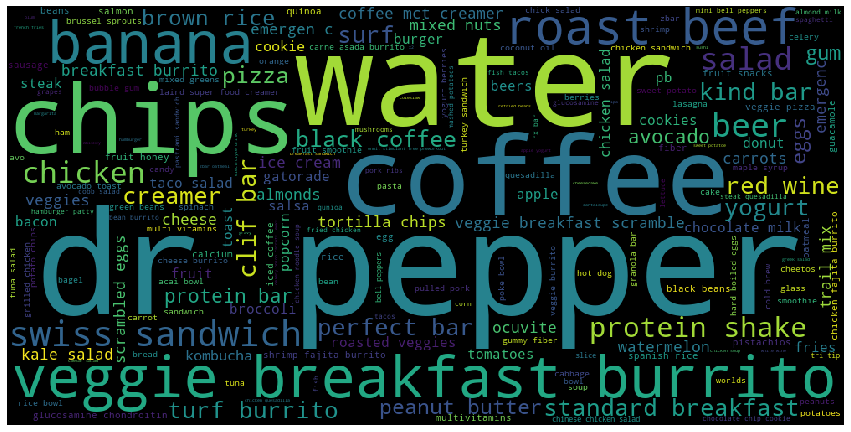

In [88]:
#Create wordcloud for the overal data

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(sorted_list)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

In [95]:
# function to create wordcloud for a sorted list of data
def generate_wordcloud(sorted_list):
    
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(sorted_list)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()

In [92]:
# function to calculate frequencies for each person
def get_freq(texts_df):
    flatten = [item for sublist in texts_df for item in sublist]
    counter = Counter(flatten)

    #Sort frequencies
    sorted_df = dict(sorted(counter.items(), key=lambda item: item[1],reverse = True))
    return sorted_df



In [93]:
#Top 10 food for 9bbi18050009

freq_df2 = get_freq(texts_df2)
freq_df2

{'iced coffee': 18,
 'laird super food creamer': 15,
 'maple syrup': 15,
 'kind bar': 9,
 'smoothie': 9,
 'salad': 6,
 'almond bars': 4,
 'oatmeal': 4,
 'peanut butter': 4,
 'kevita': 4,
 'almond milk': 4,
 'chicken veggie bowl': 3,
 'mixed nuts': 3,
 'tuna salad sandwich': 3,
 'red wine': 3,
 'trail mix': 2,
 'orange': 2,
 'cheese': 2,
 'watermelon chunks': 2,
 'brown rice': 2,
 'avocado': 2,
 'chicken rice veggies pita': 1,
 'pita bread': 1,
 'hibiscus tea': 1,
 'pesto pasta': 1,
 'shrimp': 1,
 'protein bar': 1,
 'baklava': 1,
 'rice': 1,
 'spaghetti sausage': 1,
 'grilled chicken': 1,
 'ahi sashimi': 1,
 'ice cream banana': 1,
 'salmon rice bowl': 1,
 'chicken cabbage': 1,
 'artichoke': 1,
 'chicken rice': 1,
 'egg scramble': 1,
 'sausage spinach': 1,
 'red pepper tomato soup': 1,
 'pork ribs': 1,
 'vegetable soup pita bread': 1,
 'chicken veggies brown rice': 1,
 'veggie burger': 1,
 'cabbage mix': 1,
 'pita hummus': 1,
 'chicken breast': 1,
 'ahi poke bowl': 1,
 'veggies': 1,
 'ro

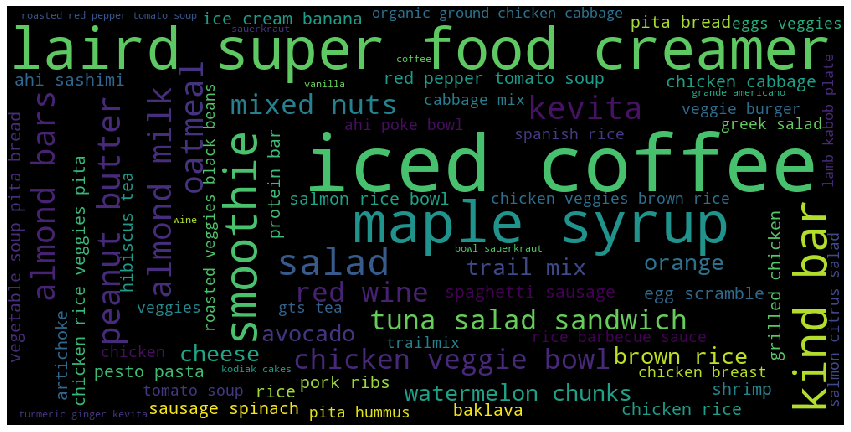

In [98]:
#generate wordcloud for 9bbi18050009
generate_wordcloud(freq_df2)

In [94]:
#Top 10 food for 9bbi18070038

freq_df3 = get_freq(texts_df3)
freq_df3

{'standard breakfast': 59,
 'black coffee': 48,
 'watermelon': 10,
 'salad': 10,
 'coconut oil': 9,
 'mixed greens': 9,
 'banana': 8,
 'bowl': 7,
 'popcorn': 7,
 'avocado': 7,
 'apple': 6,
 'celery onion carrots leeks': 6,
 'mix greens broccoli bell peppers red': 5,
 'water': 4,
 'rice': 4,
 'sweet potatoes broccoli carrots onions': 4,
 'grilled chicken': 4,
 'pb': 4,
 'coffee muscle milk bulletproof': 4,
 'octane oil': 4,
 'protien powder': 4,
 'slices pepperoni pizza': 3,
 'chopped kale mixed greens chicken salad': 3,
 'chicken': 3,
 'sauted chicken sweet potatoes': 3,
 'onions': 3,
 'cheese': 3,
 'oatmeal': 3,
 'chopped kale': 3,
 'peanut butter pretzels': 3,
 'almond milk': 3,
 'sausage': 3,
 'bell peppers': 3,
 'modelo negro cerveza': 3,
 'greek yogurt': 2,
 'in oatmeal': 2,
 'dark chocolate': 2,
 'fries': 2,
 'mixed greens avacado chicken salad': 2,
 'mixed nuts': 2,
 'fruit salad': 2,
 'homemade vegetable soup': 2,
 'protein powder': 2,
 'red cabbage': 2,
 'chicken fried rice': 

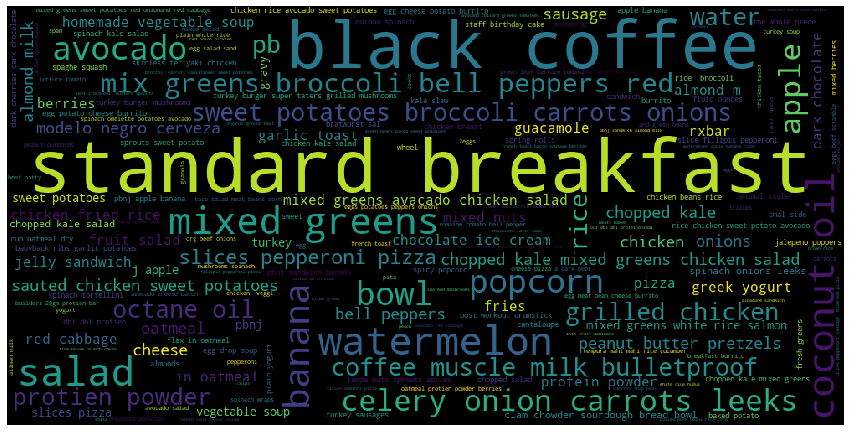

In [97]:
#generate wordcloud for 9bbi18070038
generate_wordcloud(freq_df3)

In [99]:
#Top 10 food for 9bbi18060021
freq_df4 = get_freq(texts_df4)
freq_df4

{'coffee': 70,
 'creamer': 67,
 'protein shake': 64,
 'perfect bar': 57,
 'coffee mct creamer': 36,
 'chocolate milk': 25,
 'yogurt': 18,
 'kombucha': 18,
 'fruit honey': 17,
 'pistachios': 15,
 'chicken salad': 14,
 'cold brew': 13,
 'red wine': 13,
 'breakfast burrito': 10,
 'beer': 8,
 'veggies': 7,
 'rx bar': 7,
 'chips': 7,
 'onnit stimulant free preworkout': 7,
 'poke bowl': 6,
 'ipa': 6,
 'white wine': 6,
 'chicken': 5,
 'eggs': 5,
 'celery': 5,
 'chipotle steak burrito': 5,
 'yogurt granola honey': 5,
 'protein pancakes': 5,
 'pastrami sandwich': 5,
 'brussels': 5,
 'pizza': 5,
 'bulletproof coffee': 5,
 'baby bananas': 4,
 'chicken sandwich': 4,
 'banana': 4,
 'quinoa power bowl': 4,
 'eggs ribeye spinach shrooms': 4,
 'yogurt blueberry honey granola': 4,
 'ample': 4,
 'breakfast scramble': 3,
 'tortilla chips': 3,
 'smoked ribs': 3,
 'pb': 3,
 'salad': 3,
 'pancakes': 3,
 'egg scramble': 3,
 'hamburger': 3,
 'roast': 3,
 'raw almonds': 3,
 'hamburger sweet potato': 3,
 'canta

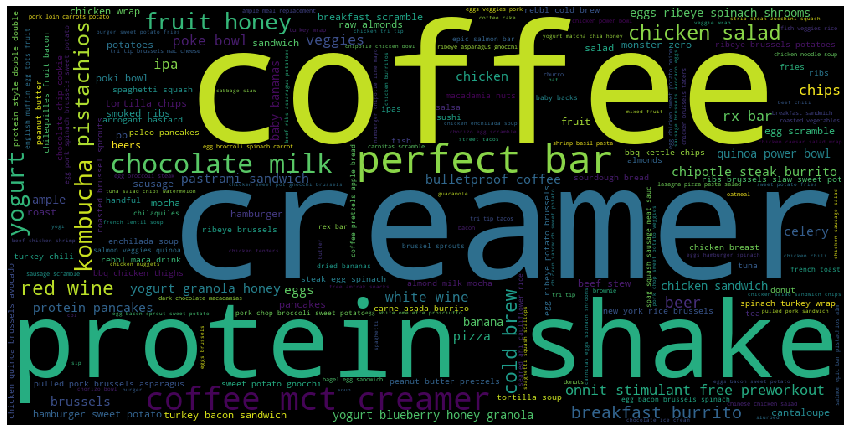

In [100]:
#generate wordcloud for 9bbi18060021
generate_wordcloud(freq_df4)

In [ ]:
#Top 10 food for 9bbi18050004
freq_df5 = get_freq(texts_df5)
freq_df5

In [ ]:
#generate wordcloud for 9bbi18050004
generate_wordcloud(freq_df5)

In [ ]:
#Top 10 food for 9bbi18050004
freq_df6 = get_freq(texts_df6)
freq_df6

In [ ]:
#generate wordcloud for 9bbi18050004
generate_wordcloud(freq_df6)

In [ ]:
#Top 10 food for 9bbi18050004
freq_df7 = get_freq(texts_df7)
freq_df7

In [ ]:
#generate wordcloud for 9bbi18050004
generate_wordcloud(freq_df7)

In [101]:
#Top 10 food for 9bbi18060018
freq_df8 = get_freq(texts_df8)
freq_df8

{'coffee': 15,
 'fruit smoothie': 12,
 'beer': 11,
 'chips': 5,
 'salsa': 5,
 'energy gel': 4,
 'ketchup': 4,
 'caesar salad': 4,
 'chicken': 3,
 'cheese': 3,
 'ranch dressing': 3,
 'ham': 2,
 'avocado salad': 2,
 'mac': 2,
 'rice': 2,
 'quesadillas': 2,
 'pepsi': 2,
 'chicken wings': 2,
 'corned beef tacos': 2,
 'potatoes': 2,
 'tri tip': 2,
 'veggies': 2,
 'french fries': 2,
 'banana': 2,
 'pasta': 2,
 'red sauce': 2,
 'garlic bread': 2,
 'baked beans': 2,
 'grilled cheese': 1,
 'chicken soup': 1,
 'nachos': 1,
 'dr pepper': 1,
 'carne assad burrito': 1,
 'tacos': 1,
 'beans': 1,
 'cheese omelette': 1,
 'loaded baked potato': 1,
 'dip': 1,
 'guacamole': 1,
 'fruit': 1,
 'carrots': 1,
 'pepperoni pizza': 1,
 'jalapeno popcorn': 1,
 'jalepenos': 1,
 'pickled onions': 1,
 'cabbage': 1,
 'sour cream': 1,
 'pizza': 1,
 'carne asada nachos': 1,
 'bacon': 1,
 'lettuce': 1,
 'tomato': 1,
 'sour dough bread': 1,
 'mayo': 1,
 'broccoli': 1,
 'white rice': 1,
 'bbq chicken': 1,
 'breakfast burr

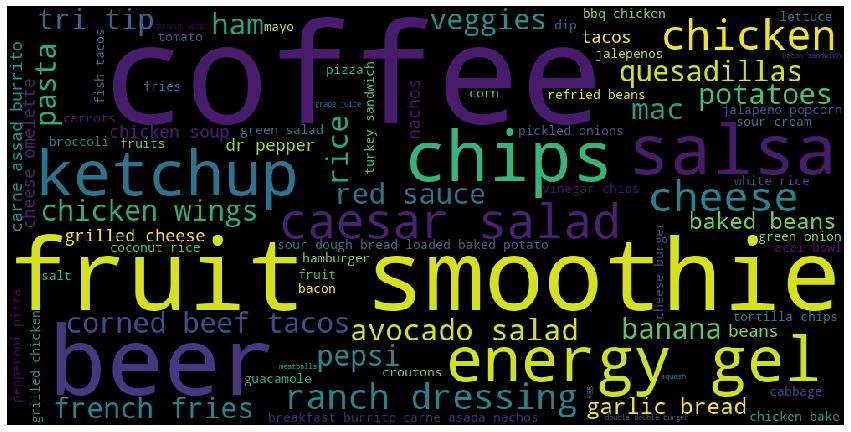

In [102]:
#generate wordcloud for 9bbi18060018
generate_wordcloud(freq_df8)

In [103]:
#Top 10 food for 9bbi18060028
freq_df9 = get_freq(texts_df9)
freq_df9

{'dr pepper': 413,
 'water': 318,
 'chips': 180,
 'veggie breakfast burrito': 161,
 'roast beef': 150,
 'swiss sandwich': 150,
 'clif bar': 80,
 'surf': 62,
 'turf burrito': 60,
 'veggie breakfast scramble': 40,
 'trail mix': 32,
 'veggies': 23,
 'shrimp fajita burrito': 20,
 'chicken': 20,
 'pizza': 20,
 'veggie pizza': 19,
 'fruit snacks': 19,
 'chicken fajita burrito': 17,
 'burger': 16,
 'black beans': 16,
 'fries': 15,
 'rice bowl': 11,
 'broccoli': 11,
 'bean': 11,
 'cheese burrito': 11,
 'zbar': 10,
 'salad': 9,
 'veggie burrito': 9,
 'worlds': 9,
 'donut': 9,
 'sweet potato': 9,
 'granola bar': 9,
 'mini bell peppers': 8,
 'steak quesadilla': 8,
 'popcorn': 8,
 'chicken quesadilla': 7,
 'zbar oatmeal': 6,
 'sweet potatoe': 6,
 'bean burrito': 6,
 'chicken club sandwich meal': 6,
 'cookies': 5,
 'breakfast sandwich': 5,
 'accelerade': 5,
 'tri tip': 4,
 'almonds': 4,
 'pot roast': 4,
 'veggie pasta': 4,
 'clif bloks energy chews': 4,
 'gatorade': 4,
 'grilled veggies': 3,
 'vegg

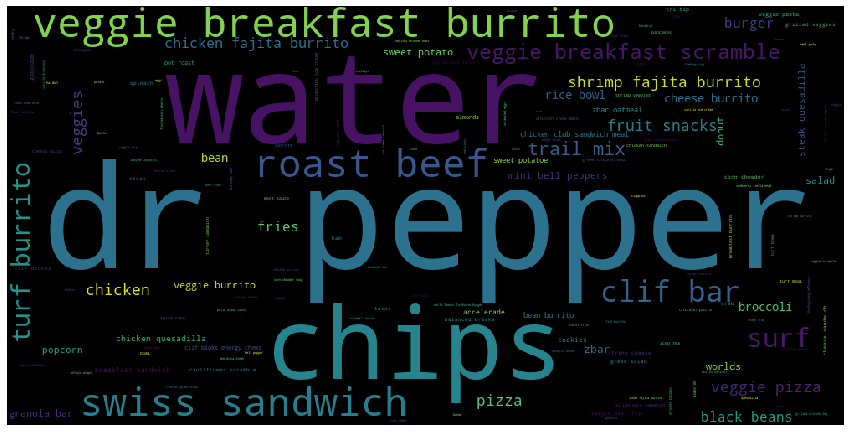

In [104]:
#generate wordcloud for 9bbi18060028
generate_wordcloud(freq_df9)

In [105]:
#Top 10 food for 9bbi18060034
freq_df10 = get_freq(texts_df10)
freq_df10

{'beer': 95,
 'chicken': 70,
 'salad': 63,
 'banana': 52,
 'red wine': 51,
 'brown rice': 45,
 'gum': 43,
 'peanut butter': 37,
 'ocuvite': 36,
 'emergenc': 35,
 'tortilla chips': 33,
 'scrambled eggs': 33,
 'protein bar': 33,
 'emergen c': 32,
 'ice cream': 32,
 'avocado': 31,
 'protein shake': 30,
 'cheese': 30,
 'mixed nuts': 28,
 'carrots': 28,
 'roasted veggies': 25,
 'cookie': 22,
 'bacon': 22,
 'tomatoes': 22,
 'glucosamine chondroitin': 21,
 'multivitamins': 21,
 'fiber': 21,
 'eggs': 19,
 'taco salad': 19,
 'steak': 18,
 'watermelon': 18,
 'salmon': 18,
 'toast': 18,
 'fruit': 18,
 'kale salad': 17,
 'calcium': 17,
 'spanish rice': 17,
 'quinoa': 15,
 'gummy fiber': 15,
 'multi vitamins': 15,
 'egg': 15,
 'almonds': 14,
 'pizza': 14,
 'gatorade': 14,
 'bubble gum': 13,
 'salsa': 13,
 'guacamole': 13,
 'lasagna': 12,
 'carrot': 12,
 'sausage': 12,
 'avocado toast': 12,
 'breakfast burrito': 12,
 'yogurt': 12,
 'popcorn': 12,
 'brussel sprouts': 11,
 'rice': 11,
 'peanuts': 11,


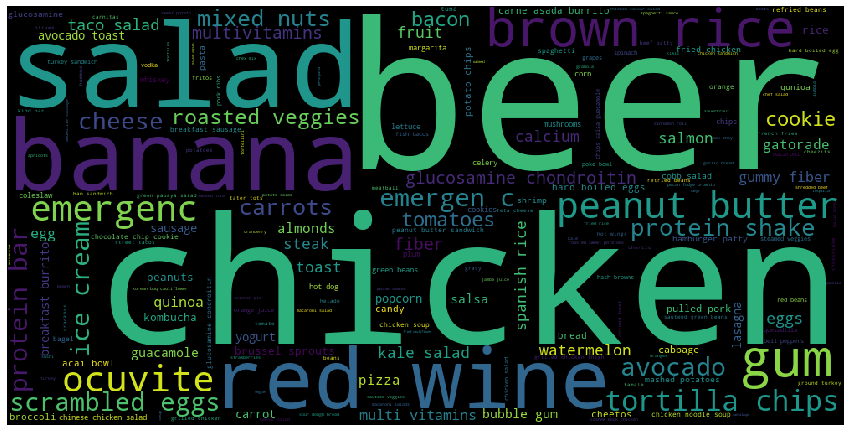

In [106]:
#generate wordcloud for 9bbi18060034
generate_wordcloud(freq_df10)